# PC algorithm for causal discovery from observational data without latent confounders

In this tutorial, we will simulate some observational data from a Structural Causal Model (SCM) and
demonstrate how we will use the PC algorithm.

The PC algorithm works on observational data when there are no unobserved latent confounders.

In [1]:
import numpy as np
import networkx as nx
from scipy import stats
from pywhy_graphs.viz import draw
from dodiscover.ci import GSquareCITest, Oracle
from dodiscover import PC, make_context
import pandas as pd
from dowhy import gcm
from dowhy.gcm.util.general import set_random_seed

## Simulate some data

First we will simulate data, starting from a Structural Causal Model (SCM).  This will then induce a causal graph, which we can visualize. Due to the Markov assumption, then we can use d-separation to examine which variables are conditionally independent.

In [2]:
# set a random seed to make example reproducible
seed = 12345
rng = np.random.RandomState(seed=seed)


class MyCustomModel(gcm.PredictionModel):
    def __init__(self, coefficient):
        self.coefficient = coefficient

    def fit(self, X, Y):
        # Nothing to fit here, since we know the ground truth.
        pass

    def predict(self, X):
        return self.coefficient * X

    def clone(self):
        # We don't really need this actually.
        return MyCustomModel(self.coefficient)

In [3]:
# set a random seed to make example reproducible
set_random_seed(1234)

# construct a causal graph that will result in
# x -> y <- z -> w
G = nx.DiGraph([("x", "y"), ("z", "y"), ("z", "w")])

causal_model = gcm.ProbabilisticCausalModel(G)
causal_model.set_causal_mechanism("x", gcm.ScipyDistribution(stats.binom, p=0.5, n=1))
causal_model.set_causal_mechanism("z", gcm.ScipyDistribution(stats.binom, p=0.9, n=1))
causal_model.set_causal_mechanism(
    "y",
    gcm.AdditiveNoiseModel(
        prediction_model=MyCustomModel(1),
        noise_model=gcm.ScipyDistribution(stats.binom, p=0.8, n=1),
    ),
)
causal_model.set_causal_mechanism(
    "w",
    gcm.AdditiveNoiseModel(
        prediction_model=MyCustomModel(1),
        noise_model=gcm.ScipyDistribution(stats.binom, p=0.5, n=1),
    ),
)

Fit here would not really fit parameters, since we don't do anything in the fit method. Here, we only need this to ensure that each FCM has the correct local hash (i.e., we get an inconsistency error if we would modify the graph afterwards without updating the FCMs). Having an empty data set is a small workaround, since all models are pre-defined.

Fitting causal mechanism of node w: 100%|████████| 4/4 [00:00<00:00, 837.35it/s]


   x  z  y  w
0  0  1  1  1
1  1  1  1  2
2  0  1  1  1
3  1  1  1  1
4  1  1  1  1
x       [0, 1]
z       [1, 0]
y    [1, 2, 0]
w    [1, 2, 0]
dtype: object


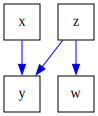

In [4]:
gcm.fit(causal_model, pd.DataFrame(columns=["x", "y", "z", "w"]))

# sample the observational data
data = gcm.draw_samples(causal_model, num_samples=500)

print(data.head())
print(pd.Series({col: data[col].unique() for col in data}))
draw(G)

In [2]:
from os import getcwd
getcwd()

pd.read_csv("data/asia.csv")

,CVP,PCWP,HIST,TPR,BP,CO,HRBP,HREK,HRSA,PAP,...,ERLO,HR,ERCA,SHNT,PVS,ACO2,VALV,VLNG,VTUB,VMCH
0,NORMAL,NORMAL,False,LOW,NORMAL,HIGH,HIGH,HIGH,HIGH,NORMAL,...,False,HIGH,False,NORMAL,NORMAL,NORMAL,HIGH,LOW,ZERO,NORMAL
1,NORMAL,NORMAL,False,NORMAL,LOW,LOW,HIGH,HIGH,HIGH,NORMAL,...,False,HIGH,False,NORMAL,LOW,LOW,ZERO,ZERO,LOW,NORMAL
2,NORMAL,HIGH,False,NORMAL,NORMAL,HIGH,HIGH,HIGH,HIGH,NORMAL,...,False,HIGH,False,NORMAL,LOW,LOW,ZERO,ZERO,LOW,NORMAL
3,NORMAL,NORMAL,False,LOW,LOW,HIGH,HIGH,HIGH,HIGH,NORMAL,...,False,HIGH,False,NORMAL,NORMAL,LOW,ZERO,ZERO,LOW,NORMAL
4,NORMAL,NORMAL,False,LOW,LOW,NORMAL,HIGH,HIGH,HIGH,NORMAL,...,False,HIGH,False,NORMAL,LOW,LOW,ZERO,ZERO,LOW,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,NORMAL,NORMAL,False,HIGH,NORMAL,LOW,LOW,LOW,LOW,NORMAL,...,False,NORMAL,False,NORMAL,LOW,NORMAL,NORMAL,ZERO,LOW,NORMAL
19996,NORMAL,NORMAL,False,HIGH,LOW,LOW,NORMAL,HIGH,HIGH,NORMAL,...,False,LOW,False,NORMAL,LOW,LOW,ZERO,ZERO,LOW,NORMAL
19997,NORMAL,NORMAL,False,LOW,LOW,NORMAL,HIGH,HIGH,HIGH,NORMAL,...,False,HIGH,False,NORMAL,LOW,LOW,ZERO,ZERO,LOW,NORMAL
19998,NORMAL,HIGH,False,LOW,LOW,HIGH,HIGH,HIGH,HIGH,HIGH,...,False,HIGH,False,NORMAL,NORMAL,LOW,HIGH,LOW,HIGH,NORMAL


![asia](figures/asia.png)

## Instantiate some conditional independence tests

To run a constraint-based structure learning algorithm such as the PC algorithm, we need a way to test for conditional independence (CI) constraints. There are various ways we can evaluate the algorithm.

If we are applying the algorithm on real data, we would want to use the CI test that best suits the data. Note that because of finite sample sizes, any CI test is bound to make some errors, which results in incorrect orientations and edges in the learned graph.

If we are interested in evaluating how the discovery algorithm works in an ideal setting, we can use an oracle, which is imbued with the ground-truth graph, which can query all the d-separation statements needed. This can help one determine in a simulation setting, what is the best case graph the PC algorithm can learn.

In [5]:
oracle = Oracle(G)
ci_estimator = GSquareCITest(data_type="discrete")

## Define the context

A common anti-pattern in causal discovery is encouraging the user to see the discovery algorithm as a philosopher's stone that converts data to causal relationships.  In other words, discovery libraries tend to encourage users tend to surrender the task of providing domain-specific assumptions that enable identifiability to the algorithm. PyWhy's key strength is how it guides users to specifying domain assumptions up front (in the form of a DAG) before the data is added, and then addresses identifiability given those assumptions and data. 

To this end, we introduce the `context.Context` class, where users provide data as the primary input to a discovery algorithm. The Context class houses both data, a priori assumptions and other relevant data that may be used in downstream structure learning algorithms.

In this example, we'll use the context object to specify some fixed edges in the graph.

In [6]:
context = make_context().variables(data=data).build()

In [7]:
#included_edges = nx.Graph([('x', 'y')])
#context = make_context().edges(include=included_edges).build()

Note that when specifying fixed edges, the resulting graph that is learned is not necessarily a "pure CPDAG". In that, there are more constraints than just the conditional independences. Therefore, one should use caution when specifying fixed edges if they are interested in leveraging ID or estimation algorithms that assume the learned structure is a "pure CPDAG".

## Run discovery algorithm

Now we are ready to run the PC algorithm. First, we will show the output of the oracle, which is the best case scenario the PC algorithm can learn given an infinite amount of data.

In [8]:
pc = PC(ci_estimator=oracle)
pc.fit(data, context)

The resulting completely partially directed acyclic graph (CPDAG) that is learned is a "Markov equivalence class", which encodes all the conditional dependences that were learned from the data.

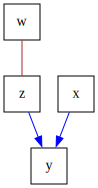

In [9]:
graph = pc.graph_
draw(graph)

Now, we will show the output given a real CI test, which performs CI hypothesis testing to determine CI in the data. Due to finite data and the presence of noise, there is always a possibility that the CI test makes a mistake.

In [10]:
pc = PC(ci_estimator=ci_estimator)
pc.fit(data, context)

/Users/robertness/Dropbox/code/dodiscover/dodiscover/ci/g_test.py:200: RuntimeWarning: divide by zero encountered in log
  log_tlog = np.log(tlog)
/Users/robertness/Dropbox/code/dodiscover/dodiscover/ci/g_test.py:201: RuntimeWarning: invalid value encountered in multiply
  G2 = np.nansum(2 * contingency_tble * log_tlog)


The resulting completely partially directed acyclic graph (CPDAG) that is learned is a "Markov equivalence class", which encodes all the conditional dependences that were learned from the data. Note here, because the CI test fails to find the dependency between 'z' and 'y', then we fail to also orient the corresponding collider in the data. This illustrates the dependency of constraint-based structure learning algorithms on the implicit Type I/II error in hypothesis tests.

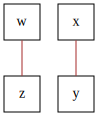

In [11]:
graph = pc.graph_
draw(graph)